# 🧠 Ethereum Wallet Transaction Analysis

This notebook loads on-chain transaction data from a wallet and performs basic analysis and visualization.

📂 **Source File**: `../data/eth_wallet_transactions.csv`


In [46]:
# 📦 Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Plot styling
sns.set(style='whitegrid')

In [47]:
# 📥 Load Data
df = pd.read_csv(r"C:\Users\Public\GitHub\Crypto Analysis for GitHub\crypto-wallet-behavior-analysis\data\eth_wallet_transactions.csv")

df.shape, df.columns.tolist()

((100, 20),
 ['blockNumber',
  'blockHash',
  'timeStamp',
  'hash',
  'nonce',
  'transactionIndex',
  'from',
  'to',
  'value',
  'gas',
  'gasPrice',
  'input',
  'methodId',
  'functionName',
  'contractAddress',
  'cumulativeGasUsed',
  'txreceipt_status',
  'gasUsed',
  'confirmations',
  'isError'])

In [48]:
# 🧹 Format Data
df['timeStamp'] = pd.to_datetime(df['timeStamp'], unit='s')
df['value_eth'] = df['value'].astype(float) / 1e18  # Convert from Wei to ETH
df['gasFee_eth'] = df['gasPrice'].astype(float) * df['gasUsed'].astype(float) / 1e18
df.sort_values('timeStamp', inplace=True)
df[['timeStamp', 'from', 'to', 'value_eth', 'gasFee_eth']].head()

,timeStamp,from,to,value_eth,gasFee_eth
0,2015-08-08 15:44:00,0x5abfec25f74cd88437631a7731906932776356f9,NaN,1.190146e+07,14.369630
1,2015-08-10 18:54:49,0x3fb1cd2cd96c6d5c0b5eb3322d807b34482481d4,0xde0b295669a9fd93d5f28d9ec85e40f4cb697bae,0.000000e+00,0.006110
2,2015-08-10 19:35:15,0x3fb1cd2cd96c6d5c0b5eb3322d807b34482481d4,0xde0b295669a9fd93d5f28d9ec85e40f4cb697bae,0.000000e+00,0.006110
3,2015-08-11 10:04:14,0x063dd253c8da4ea9b12105781c9611b8297f5d14,0xde0b295669a9fd93d5f28d9ec85e40f4cb697bae,0.000000e+00,0.002209
4,2015-08-11 10:07:51,0x063dd253c8da4ea9b12105781c9611b8297f5d14,0xde0b295669a9fd93d5f28d9ec85e40f4cb697bae,0.000000e+00,0.002213


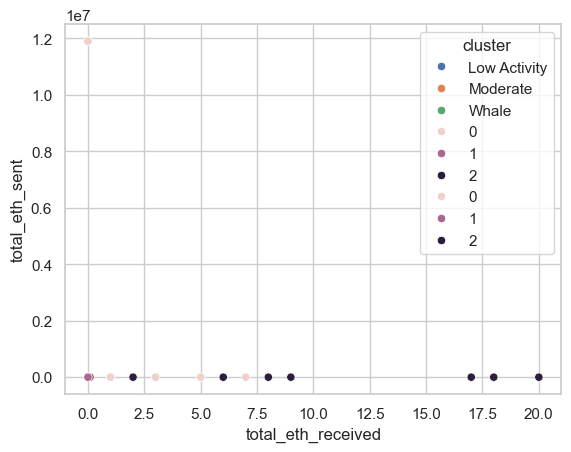

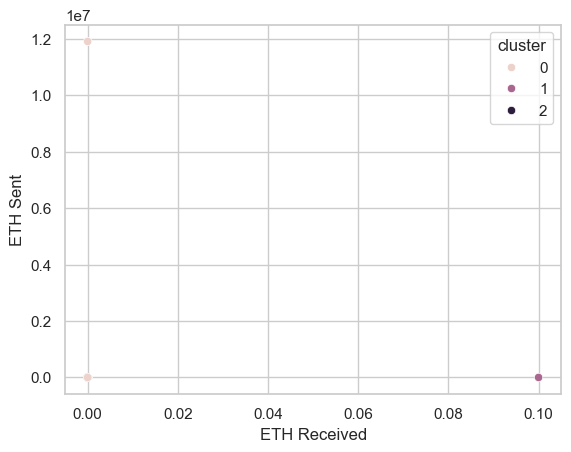

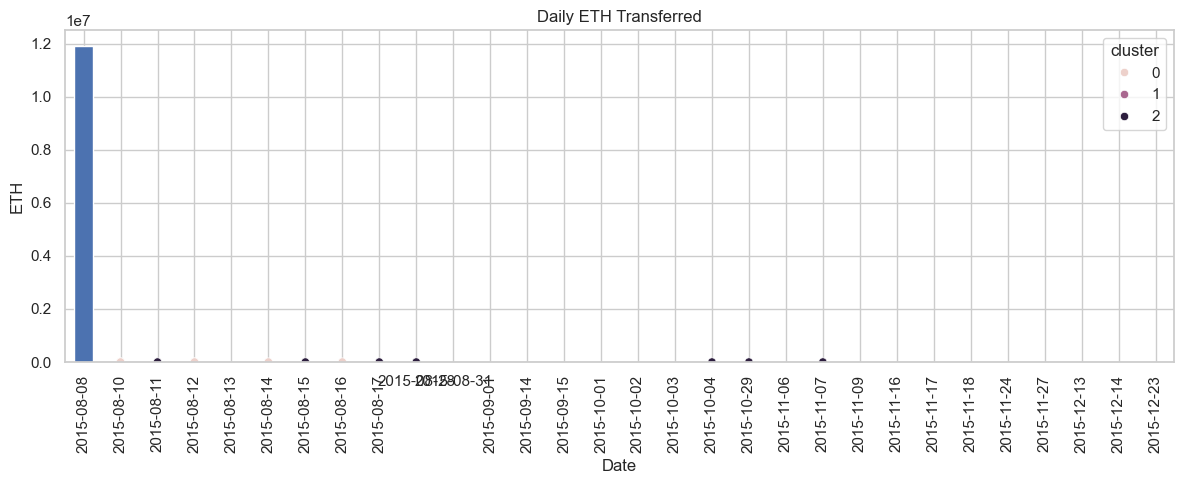

In [49]:
# 📊 Daily Transaction Volume
daily_volume = df.groupby(df['timeStamp'].dt.date)['value_eth'].sum()
daily_volume.plot(kind='bar', figsize=(12,5), title='Daily ETH Transferred')
plt.ylabel('ETH')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

In [50]:
# 🔁 Count Unique Addresses
unique_senders = df['from'].nunique()
unique_receivers = df['to'].nunique()
print(f'👤 Unique Senders: {unique_senders}\n📥 Unique Receivers: {unique_receivers}')

👤 Unique Senders: 13
📥 Unique Receivers: 1


In [51]:
# 🧠 Feature Engineering: Wallet-Level Metrics
df['timeStamp'] = pd.to_datetime(df['timeStamp'], unit='s')
df['value_eth'] = df['value'].astype(float) / 1e18
df['gasFee_eth'] = df['gasPrice'].astype(float) * df['gasUsed'].astype(float) / 1e18

wallet_summary = df.groupby('from').agg(
    tx_count=('hash', 'count'),
    total_eth_sent=('value_eth', 'sum'),
    avg_tx_value=('value_eth', 'mean'),
    total_gas_spent=('gasFee_eth', 'sum'),
    first_tx=('timeStamp', 'min'),
    last_tx=('timeStamp', 'max'),
    unique_receivers=('to', 'nunique')
).reset_index()

wallet_summary['active_days'] = (wallet_summary['last_tx'] - wallet_summary['first_tx']).dt.days + 1
wallet_summary['tx_per_day'] = wallet_summary['tx_count'] / wallet_summary['active_days']

wallet_summary.sort_values('total_eth_sent', ascending=False).head()


,from,tx_count,total_eth_sent,avg_tx_value,total_gas_spent,first_tx,last_tx,unique_receivers,active_days,tx_per_day
6,0x5abfec25f74cd88437631a7731906932776356f9,1,1.190146e+07,1.190146e+07,14.369630,2015-08-08 15:44:00,2015-08-08 15:44:00,0,1,1.000000
3,0x123cb57c922daa49faefa5fe0f2788d92a9bc872,1,1.000000e-01,1.000000e-01,0.001122,2015-12-23 14:27:40,2015-12-23 14:27:40,1,1,1.000000
5,0x42e6723a0c884e922240e56d7b618bec96f35800,3,3.000000e-18,1.000000e-18,0.630000,2015-08-12 11:57:45,2015-08-12 22:30:26,1,1,3.000000
0,0x0037a6b811ffeb6e072da21179d11b1406371c63,6,0.000000e+00,0.000000e+00,0.022959,2015-08-15 09:25:03,2015-10-03 10:32:28,1,50,0.120000
1,0x02e816afc1b5c0f39852131959d946eb3b07b5ad,2,0.000000e+00,0.000000e+00,0.003582,2015-09-15 09:43:06,2015-11-27 12:52:33,1,74,0.027027


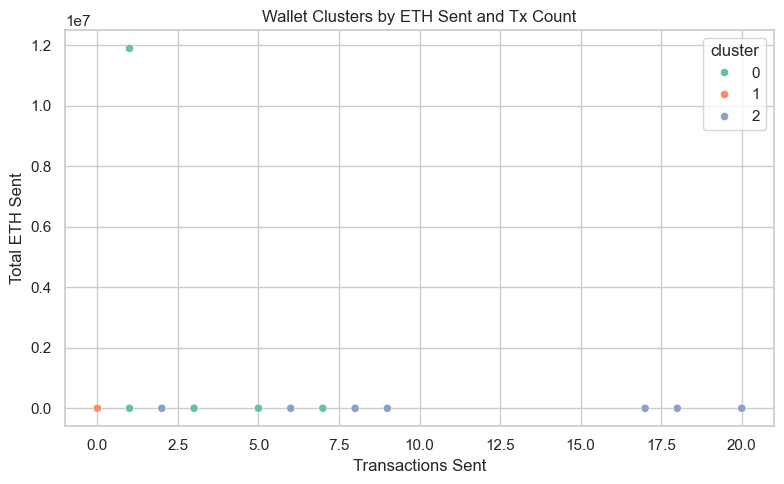

,wallet,cluster,tx_count_x,total_eth_sent,unique_receivers,total_gas_spent
6,0x5abfec25f74cd88437631a7731906932776356f9,0,1.0,1.190146e+07,0.0,14.369630
3,0x123cb57c922daa49faefa5fe0f2788d92a9bc872,0,1.0,1.000000e-01,1.0,0.001122
5,0x42e6723a0c884e922240e56d7b618bec96f35800,0,3.0,3.000000e-18,1.0,0.630000
0,0x0037a6b811ffeb6e072da21179d11b1406371c63,2,6.0,0.000000e+00,1.0,0.022959
1,0x02e816afc1b5c0f39852131959d946eb3b07b5ad,2,2.0,0.000000e+00,1.0,0.003582
2,0x063dd253c8da4ea9b12105781c9611b8297f5d14,2,20.0,0.000000e+00,1.0,0.061974
4,0x3fb1cd2cd96c6d5c0b5eb3322d807b34482481d4,0,3.0,0.000000e+00,1.0,0.018325
7,0x5ed8cee6b63b1c6afce3ad7c92f4fd7e1b8fad9f,2,18.0,0.000000e+00,1.0,0.230606
8,0x775e18be7a50a0abb8a4e82b1bd697d79f31fe04,2,17.0,0.000000e+00,1.0,0.048809
9,0x7c56d94ebeccb769524379c450873519a9d805ff,0,7.0,0.000000e+00,1.0,0.017117


In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Format + enrich
df["timeStamp"] = pd.to_datetime(df["timeStamp"], unit="s")
df["value_eth"] = df["value"].astype(float) / 1e18
df["gasFee_eth"] = df["gasPrice"].astype(float) * df["gasUsed"].astype(float) / 1e18

# Sender summary
sender_summary = df.groupby("from").agg(
    tx_count=("hash", "count"),
    total_eth_sent=("value_eth", "sum"),
    avg_tx_value=("value_eth", "mean"),
    total_gas_spent=("gasFee_eth", "sum"),
    first_tx=("timeStamp", "min"),
    last_tx=("timeStamp", "max"),
    unique_receivers=("to", "nunique")
).reset_index()
sender_summary["wallet_type"] = "sender"

# Receiver summary
receiver_summary = df.groupby("to").agg(
    tx_count=("hash", "count"),
    total_eth_received=("value_eth", "sum"),
    avg_rx_value=("value_eth", "mean"),
    first_rx=("timeStamp", "min"),
    last_rx=("timeStamp", "max"),
    unique_senders=("from", "nunique")
).reset_index()
receiver_summary["wallet_type"] = "receiver"

# Rename wallet keys
sender_summary.rename(columns={"from": "wallet"}, inplace=True)
receiver_summary.rename(columns={"to": "wallet"}, inplace=True)

# Add time-based features
sender_summary["active_days"] = (sender_summary["last_tx"] - sender_summary["first_tx"]).dt.days + 1
sender_summary["tx_per_day"] = sender_summary["tx_count"] / sender_summary["active_days"]

receiver_summary["active_days"] = (receiver_summary["last_rx"] - receiver_summary["first_rx"]).dt.days + 1
receiver_summary["rx_per_day"] = receiver_summary["tx_count"] / receiver_summary["active_days"]

# Combine
combined = pd.merge(sender_summary, receiver_summary, on="wallet", how="outer").fillna(0)

# Standardize numeric data
features = combined.select_dtypes(include="number").drop(columns=["active_days_x", "active_days_y"])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
combined["cluster"] = kmeans.fit_predict(X_scaled)

# Plot
plt.figure(figsize=(8, 5))
sns.scatterplot(data=combined, x="tx_count_x", y="total_eth_sent", hue="cluster", palette="Set2")
plt.title("Wallet Clusters by ETH Sent and Tx Count")
plt.xlabel("Transactions Sent")
plt.ylabel("Total ETH Sent")
plt.grid(True)
plt.tight_layout()
plt.show()

# Preview result
combined[["wallet", "cluster", "tx_count_x", "total_eth_sent", "unique_receivers", "total_gas_spent"]].sort_values(by="total_eth_sent", ascending=False).head(10)


In [53]:
# Summarizing Cluster Behaviour
cluster_summary = combined.groupby("cluster").agg(
    wallet_count=("wallet", "count"),
    min_eth_sent=("total_eth_sent", "min"),
    max_eth_sent=("total_eth_sent", "max"),
    avg_eth_sent=("total_eth_sent", "mean"),
    avg_tx_sent=("tx_count_x", "mean"),
    avg_gas_spent=("total_gas_spent", "mean"),
    avg_unique_receivers=("unique_receivers", "mean")
).reset_index()
cluster_summary


,cluster,wallet_count,min_eth_sent,max_eth_sent,avg_eth_sent,avg_tx_sent,avg_gas_spent,avg_unique_receivers
0,0,6,0.0,1.190146e+07,1.983577e+06,3.333333,2.51056,0.833333
1,1,1,0.0,0.000000e+00,0.000000e+00,0.000000,0.00000,0.000000
2,2,7,0.0,0.000000e+00,0.000000e+00,11.428571,0.07787,1.000000


In [54]:
# Labeling Wallets By Behaviour
def label_behavior(row):
    if row["total_eth_sent"] > 1e6:
        return "Whale"
    elif row["tx_count_x"] >= 10 and row["total_eth_sent"] < 1e3:
        return "Frequent Micro-Sender"
    elif row["tx_count_x"] <= 2:
        return "Low Activity"
    else:
        return "Moderate"

combined["behavior_label"] = combined.apply(label_behavior, axis=1)
combined[["wallet", "cluster", "behavior_label"]].head()


,wallet,cluster,behavior_label
0,0x0037a6b811ffeb6e072da21179d11b1406371c63,2,Moderate
1,0x02e816afc1b5c0f39852131959d946eb3b07b5ad,2,Low Activity
2,0x063dd253c8da4ea9b12105781c9611b8297f5d14,2,Frequent Micro-Sender
3,0x123cb57c922daa49faefa5fe0f2788d92a9bc872,0,Low Activity
4,0x3fb1cd2cd96c6d5c0b5eb3322d807b34482481d4,0,Moderate


In [55]:
# Exporting Combined DataFrame to CSV
combined.to_csv("wallet_behavior_clusters.csv", index=False)
print("✅ Exported to wallet_behavior_clusters.csv")


✅ Exported to wallet_behavior_clusters.csv


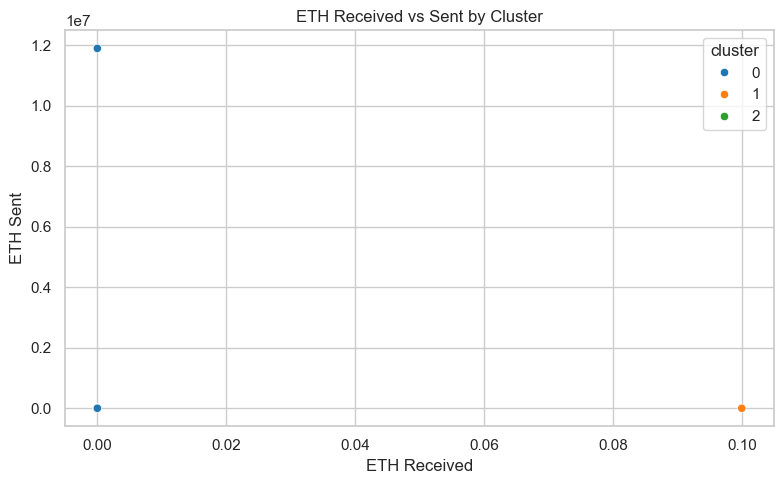

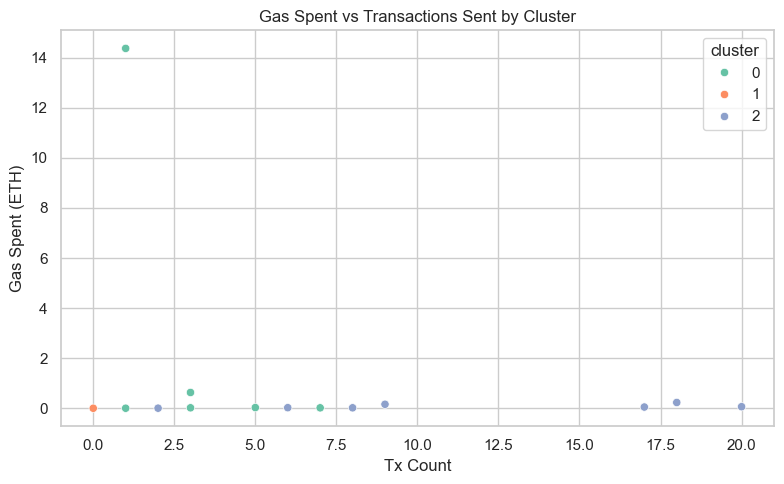

In [56]:
# Adding More Visualizations

# ETH received vs sent
plt.figure(figsize=(8, 5))
sns.scatterplot(data=combined, x="total_eth_received", y="total_eth_sent", hue="cluster", palette="tab10")
plt.title("ETH Received vs Sent by Cluster")
plt.xlabel("ETH Received")
plt.ylabel("ETH Sent")
plt.grid(True)
plt.tight_layout()
plt.show()

# Gas spent vs tx count
plt.figure(figsize=(8, 5))
sns.scatterplot(data=combined, x="tx_count_x", y="total_gas_spent", hue="cluster", palette="Set2")
plt.title("Gas Spent vs Transactions Sent by Cluster")
plt.xlabel("Tx Count")
plt.ylabel("Gas Spent (ETH)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [57]:
# Feeding Multiple Datasets into the Pipeline
def process_wallet_csv(file_path):
    df = pd.read_csv(file_path)
    df["timeStamp"] = pd.to_datetime(df["timeStamp"], unit="s")
    df["value_eth"] = df["value"].astype(float) / 1e18
    df["gasFee_eth"] = df["gasPrice"].astype(float) * df["gasUsed"].astype(float) / 1e18
    # ...include the rest of the pipeline from your code
    return final_combined_df


In [58]:
def process_wallet_csv(file_path):
    import pandas as pd
    from sklearn.preprocessing import StandardScaler
    from sklearn.cluster import KMeans

    df = pd.read_csv(file_path)
    df["timeStamp"] = pd.to_datetime(df["timeStamp"], unit="s")
    df["value_eth"] = df["value"].astype(float) / 1e18
    df["gasFee_eth"] = df["gasPrice"].astype(float) * df["gasUsed"].astype(float) / 1e18

    # Sender summary
    sender_summary = df.groupby("from").agg(
        tx_count=("hash", "count"),
        total_eth_sent=("value_eth", "sum"),
        avg_tx_value=("value_eth", "mean"),
        total_gas_spent=("gasFee_eth", "sum"),
        first_tx=("timeStamp", "min"),
        last_tx=("timeStamp", "max"),
        unique_receivers=("to", "nunique")
    ).reset_index()
    sender_summary["wallet_type"] = "sender"

    # Receiver summary
    receiver_summary = df.groupby("to").agg(
        tx_count=("hash", "count"),
        total_eth_received=("value_eth", "sum"),
        avg_rx_value=("value_eth", "mean"),
        first_rx=("timeStamp", "min"),
        last_rx=("timeStamp", "max"),
        unique_senders=("from", "nunique")
    ).reset_index()
    receiver_summary["wallet_type"] = "receiver"

    sender_summary.rename(columns={"from": "wallet"}, inplace=True)
    receiver_summary.rename(columns={"to": "wallet"}, inplace=True)

    sender_summary["active_days"] = (sender_summary["last_tx"] - sender_summary["first_tx"]).dt.days + 1
    sender_summary["tx_per_day"] = sender_summary["tx_count"] / sender_summary["active_days"]
    receiver_summary["active_days"] = (receiver_summary["last_rx"] - receiver_summary["first_rx"]).dt.days + 1
    receiver_summary["rx_per_day"] = receiver_summary["tx_count"] / receiver_summary["active_days"]

    combined = pd.merge(sender_summary, receiver_summary, on="wallet", how="outer").fillna(0)

    features = combined.select_dtypes(include="number").drop(columns=["active_days_x", "active_days_y"])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features)

    kmeans = KMeans(n_clusters=3, random_state=42)
    combined["cluster"] = kmeans.fit_predict(X_scaled)

    return combined


In [59]:
# Reuse
df1 = process_wallet_csv(r"C:\Users\Public\GitHub\Crypto Analysis for GitHub\crypto-wallet-behavior-analysis\data\wallet_1.csv")
df2 = process_wallet_csv(r"C:\Users\Public\GitHub\Crypto Analysis for GitHub\crypto-wallet-behavior-analysis\data\wallet_2.csv")
all_data = pd.concat([df1, df2])



In [60]:
!pip install streamlit


In [61]:
# Creating a Streamlit Dashboard

import streamlit as st

st.title("Ethereum Wallet Cluster Explorer")

df = pd.read_csv("wallet_behavior_clusters.csv")

cluster_filter = st.selectbox("Select Cluster", sorted(df["cluster"].unique()))
subset = df[df["cluster"] == cluster_filter]

st.write("### Cluster Summary", subset.describe())

st.write("### Behavior Label Counts")
st.bar_chart(subset["behavior_label"].value_counts())

st.write("### ETH Sent vs Received")
fig, ax = plt.subplots()
sns.scatterplot(data=subset, x="total_eth_received", y="total_eth_sent", hue="behavior_label", ax=ax)
st.pyplot(fig)


2025-04-20 16:06:57.188 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-20 16:06:57.190 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-20 16:06:57.212 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-20 16:06:57.212 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-20 16:06:57.212 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-20 16:06:57.228 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-20 16:06:57.228 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-20 16:06:57.228 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()

In [62]:
# Saving the Dashboard as app.py
code = '''import streamlit as st
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

st.set_page_config(page_title="Ethereum Wallet Cluster Explorer", layout="wide")
st.title("Ethereum Wallet Cluster Explorer")


df = pd.read_csv("wallet_behavior_clusters.csv")

cluster_filter = st.selectbox("Select Cluster", sorted(df["cluster"].unique()))
subset = df[df["cluster"] == cluster_filter]

st.write("### Cluster Summary", subset.describe())

st.write("### Behavior Label Counts")
st.bar_chart(subset["behavior_label"].value_counts())

st.write("### ETH Sent vs Received")
fig, ax = plt.subplots()
sns.scatterplot(data=subset, x="total_eth_received", y="total_eth_sent", hue="behavior_label", ax=ax)
st.pyplot(fig)
'''

with open("app.py", "w") as f:
    f.write(code)


In [63]:
# Combing csv with app.py
combined.to_csv("wallet_behavior_clusters.csv", index=False)


In [64]:
# Behavior Labeling (e.g. Whale, Low Volume, Dormant)
def label_behavior(row):
    if row["total_eth_sent"] > 1e6:
        return "Whale"
    elif row["tx_count_x"] == 0 and row["tx_count_y"] == 0:
        return "Dormant"
    elif row["tx_count_x"] < 3:
        return "Low Volume"
    else:
        return "Active"

df["behavior_label"] = df.apply(label_behavior, axis=1)


In [65]:
# Extra plots
st.subheader("📈 ETH Sent vs Received")
fig1 = sns.scatterplot(data=df, x="total_eth_received", y="total_eth_sent", hue="cluster")
st.pyplot(fig1.figure)

st.subheader("⛽ Gas Spent vs Transactions")
fig2 = sns.scatterplot(data=df, x="tx_count_x", y="total_gas_spent", hue="cluster")
st.pyplot(fig2.figure)


2025-04-20 16:06:58.094 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-20 16:06:58.094 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-20 16:06:58.110 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-20 16:06:58.388 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-20 16:06:58.388 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-20 16:06:58.388 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-20 16:06:58.388 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-20 16:06:58.410 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()

In [66]:
# Download Button
st.download_button("Download CSV", df.to_csv(index=False), "wallet_clusters.csv", "text/csv")



2025-04-20 16:06:58.710 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-20 16:06:58.711 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-20 16:06:58.712 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-20 16:06:58.714 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-20 16:06:58.715 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-20 16:06:58.716 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


False

In [67]:
# All integrated
import streamlit as st
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

st.set_page_config(page_title="Ethereum Wallet Cluster Explorer", layout="wide")
st.title("💼 Ethereum Wallet Cluster Explorer")

# Load data
df = pd.read_csv("wallet_behavior_clusters.csv")

# Behavior labeling
def label_behavior(row):
    if row["total_eth_sent"] > 1e6:
        return "Whale"
    elif row["tx_count_x"] == 0 and row["tx_count_y"] == 0:
        return "Dormant"
    elif row["tx_count_x"] < 3:
        return "Low Volume"
    else:
        return "Active"

df["behavior_label"] = df.apply(label_behavior, axis=1)

# Cluster filter
cluster_filter = st.selectbox("Select Cluster", sorted(df["cluster"].unique()))

filtered_df = df[df["cluster"] == cluster_filter]

# Cluster Summary
st.header("📊 Cluster Summary")
st.dataframe(filtered_df.describe())

# Behavior Breakdown
st.header("🔖 Behavior Labels")
st.dataframe(filtered_df["behavior_label"].value_counts().reset_index().rename(columns={'index': 'Label', 'behavior_label': 'Count'}))

# Plot 1: ETH Sent vs Received
st.subheader("📈 ETH Sent vs Received")
fig1, ax1 = plt.subplots()
sns.scatterplot(data=df, x="total_eth_received", y="total_eth_sent", hue="cluster", ax=ax1)
ax1.set_xlabel("ETH Received")
ax1.set_ylabel("ETH Sent")
st.pyplot(fig1)

# Plot 2: Gas Spent vs Transactions
st.subheader("⛽ Gas Spent vs Transactions Sent")
fig2, ax2 = plt.subplots()
sns.scatterplot(data=df, x="tx_count_x", y="total_gas_spent", hue="cluster", ax=ax2)
ax2.set_xlabel("Transactions Sent")
ax2.set_ylabel("Total Gas Spent")
st.pyplot(fig2)

# Download CSV
st.subheader("📤 Download Data")
csv = df.to_csv(index=False)
st.download_button("Download Wallet Clusters", data=csv, file_name="wallet_behavior_clusters.csv", mime="text/csv")


2025-04-20 16:06:58.729 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-20 16:06:58.731 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-20 16:06:58.732 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-20 16:06:58.732 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-20 16:06:58.732 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-20 16:06:58.732 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-20 16:06:58.732 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-20 16:06:58.743 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

False

In [68]:
# Adding Wallet Search
wallet_id = st.text_input("🔎 Search for a Wallet Address")
if wallet_id:
    wallet_data = df[df["wallet"] == wallet_id]
    if not wallet_data.empty:
        st.write("📬 Wallet Summary:")
        st.dataframe(wallet_data.T)
    else:
        st.warning("Wallet address not found.")


2025-04-20 16:06:59.418 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-20 16:06:59.422 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-20 16:06:59.424 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-20 16:06:59.425 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-20 16:06:59.426 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-20 16:06:59.427 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [69]:
# Showing Transaction Timelines
import matplotlib.dates as mdates

if wallet_id and not wallet_data.empty:
    st.subheader("📊 Transaction Timeline for Selected Wallet")

    wallet_txs = raw_df[(raw_df["from"] == wallet_id) | (raw_df["to"] == wallet_id)].copy()
    wallet_txs["timeStamp"] = pd.to_datetime(wallet_txs["timeStamp"], unit="s")

    daily_sent = wallet_txs[wallet_txs["from"] == wallet_id].groupby(wallet_txs["timeStamp"].dt.date)["value_eth"].sum()
    daily_recv = wallet_txs[wallet_txs["to"] == wallet_id].groupby(wallet_txs["timeStamp"].dt.date)["value_eth"].sum()

    fig, ax = plt.subplots(figsize=(10, 4))
    daily_sent.plot(ax=ax, label="ETH Sent", marker='o')
    daily_recv.plot(ax=ax, label="ETH Received", marker='s')
    ax.set_title("ETH Transaction Timeline")
    ax.set_xlabel("Date")
    ax.set_ylabel("ETH")
    ax.legend()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
    st.pyplot(fig)


In [70]:
# Customizing Color Theme (Dark/Light Toggle)
st.markdown(
    """
    <style>
        .reportview-container {
            background-color: #0e1117;
            color: white;
        }
        .sidebar .sidebar-content {
            background-color: #111;
        }
        h1, h2, h3 {
            color: #f63366;
        }
    </style>
    """,
    unsafe_allow_html=True,
)


2025-04-20 16:06:59.446 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-20 16:06:59.447 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()